In [1]:
!python --version

Python 3.10.13


In [2]:
from PIL import Image
import os
import concurrent.futures
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
import seaborn as sns
import csv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, BatchNormalization, Dropout, Layer, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-08-28 01:51:11.331219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 01:51:11.331344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 01:51:11.478178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class StochasticDepth(Layer):
    def __init__(self, drop_rate, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_rate = drop_rate

    def call(self, x, training=None):
        if training:
            # Apply stochastic depth during training
            survival_rate = 1.0 - self.drop_rate
            batch_size = tf.shape(x)[0]
            random_tensor = survival_rate + tf.random.uniform([batch_size, 1, 1, 1])
            binary_tensor = tf.floor(random_tensor)
            x = tf.nn.dropout(x, survival_rate) * binary_tensor
        return x

def apply_stochastic_depth(model, drop_rate):
    """Apply stochastic depth to all residual blocks in the model."""
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.Add):
            residual_path = layer.input[1]  # Assuming the residual path is the second input
            stochastic_depth = StochasticDepth(drop_rate)
            new_residual = stochastic_depth(residual_path)
            
            # Create a new Add layer with the stochastic depth applied
            new_add = tf.keras.layers.Add()([layer.input[0], new_residual])
            
            # Replace the old Add layer with the new one
            model.layers[i] = new_add
    return model

In [4]:
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, warmup_steps, alpha=0.0):
        super(WarmUpCosineDecay, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)

        warmup_lr = self.initial_learning_rate * (step / warmup_steps)
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (1 - self.alpha) * self.initial_learning_rate * cosine_decay + self.alpha * self.initial_learning_rate
        
        return tf.cond(
            step < warmup_steps,
            lambda: warmup_lr,
            lambda: decayed_lr
        )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_steps": self.decay_steps,
            "warmup_steps": self.warmup_steps,
            "alpha": self.alpha,
        }


In [6]:
# Define hyperparameters
random_state = 13
batch_size = 32  # Define your batch size
initial_lr = 0.0001
warmup_epochs = 5
total_epochs = 10  # Example total epochs, adjust as needed
weight_decay = 0.05
alpha = initial_lr/10  # Minimum learning rate value as a fraction of the initial learning rate
label_smoothing = 0.1
drop_rate = 0.1  # Probability of a layer getting dropped in stochastic depth
input_shape = (224, 224, 3)
image_size = [input_shape[0], input_shape[1]]
np.random.seed(random_state)
tf.keras.utils.set_random_seed(random_state)

total_images = 1000  # Update with your actual dataset size

# Calculate training steps per epoch
number_of_training_steps_per_epoch = total_images // batch_size

In [7]:
def total_files(folder_path):
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return num_files

train_files_healthy = "/kaggle/input/plant-disease-recognition-dataset/Train/Train/Healthy"
train_files_powdery = "/kaggle/input/plant-disease-recognition-dataset/Train/Train/Powdery"
train_files_rust = "/kaggle/input/plant-disease-recognition-dataset/Train/Train/Rust"

test_files_healthy = "/kaggle/input/plant-disease-recognition-dataset/Test/Test/Healthy"
test_files_powdery = "/kaggle/input/plant-disease-recognition-dataset/Test/Test/Powdery"
test_files_rust = "/kaggle/input/plant-disease-recognition-dataset/Test/Test/Rust"

valid_files_healthy = "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy"
valid_files_powdery = "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Powdery"
valid_files_rust = "/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust"

print("Number of healthy leaf images in training set", total_files(train_files_healthy))
print("Number of powder leaf images in training set", total_files(train_files_powdery))
print("Number of rusty leaf images in training set", total_files(train_files_rust))

print("========================================================")

print("Number of healthy leaf images in test set", total_files(test_files_healthy))
print("Number of powder leaf images in test set", total_files(test_files_powdery))
print("Number of rusty leaf images in test set", total_files(test_files_rust))

print("========================================================")

print("Number of healthy leaf images in validation set", total_files(valid_files_healthy))
print("Number of powder leaf images in validation set", total_files(valid_files_powdery))
print("Number of rusty leaf images in validation set", total_files(valid_files_rust))

Number of healthy leaf images in training set 458
Number of powder leaf images in training set 430
Number of rusty leaf images in training set 434
Number of healthy leaf images in test set 50
Number of powder leaf images in test set 50
Number of rusty leaf images in test set 50
Number of healthy leaf images in validation set 20
Number of powder leaf images in validation set 20
Number of rusty leaf images in validation set 20


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_dataset = train_datagen.flow_from_directory('/kaggle/input/plant-disease-recognition-dataset/Train/Train',
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_dataset = test_datagen.flow_from_directory('/kaggle/input/plant-disease-recognition-dataset/Test/Test',
                                                        target_size=image_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
validation_dataset = val_datagen.flow_from_directory('/kaggle/input/plant-disease-recognition-dataset/Validation/Validation',
                                                        target_size=image_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [12]:
base_model = keras.applications.ResNet50(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
)

base_model = apply_stochastic_depth(base_model, drop_rate)
print(len(base_model.layers))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
175


In [13]:
# Calculate the number of steps for warmup and total decay
total_steps = number_of_training_steps_per_epoch * total_epochs
warmup_steps = number_of_training_steps_per_epoch * warmup_epochs

# Instantiate the learning rate schedule
lr_schedule = WarmUpCosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=total_steps - warmup_steps,
    warmup_steps=warmup_steps,
    alpha=alpha
)

In [14]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
predictions = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

Transfer Learning

In [20]:
file_name = input("Designate a name to this experiment's records -")
csv_logger = CSVLogger('transfer_learning_' + file_name, append=True)

history = model.fit(train_dataset,
          epochs=total_epochs,
          validation_data=validation_dataset,
                   callbacks=[csv_logger])

Designate a name to this experiment's records - plantdesiesepredictionResnet50


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2578 - loss: 69.9288  

I0000 00:00:1724810064.836267     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3209 - loss: 69.5563 - val_accuracy: 0.4167 - val_loss: 67.2264
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3350 - loss: 65.7537 - val_accuracy: 0.3333 - val_loss: 60.1771
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3433 - loss: 57.7215 - val_accuracy: 0.3667 - val_loss: 49.9891
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.3523 - loss: 47.1827 - val_accuracy: 0.4000 - val_loss: 38.6939
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3238 - loss: 36.3567 - val_accuracy: 0.3333 - val_loss: 30.4389
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.3690 - loss: 29.1558 - val_accuracy: 0.5000 - val_loss: 26.3798
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3583 - loss: 25.9769 - val_accuracy: 0.3833 - val_loss: 25.3184
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3745 - loss: 25.3092 - val_accuracy: 0.4000 - val_

In [21]:
tf.keras.backend.clear_session()

Fine Tuning

In [22]:
for layer in base_model.layers[-100:]:  # Example: unfreeze the last 50 layers
    layer.trainable = True

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Trainable params: 24,253,187 (92.52 MB)

 Non-trainable params: 1,435,776 (5.48 MB)

In [25]:
csv_logger = CSVLogger('finetuning_' + file_name, append=True)

history = model.fit(train_dataset,
          epochs=total_epochs + 10,
          validation_data=validation_dataset,
                   callbacks=[csv_logger])

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.4981 - loss: 18.1641 - val_accuracy: 0.3333 - val_loss: 15.8982
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7022 - loss: 12.8479 - val_accuracy: 0.3333 - val_loss: 13.7165
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7138 - loss: 9.0820 - val_accuracy: 0.3333 - val_loss: 11.4987
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7525 - loss: 6.4240 - val_accuracy: 0.3333 - val_loss: 12.4718
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8231 - loss: 4.4848 - val_accuracy: 0.3500 - val_loss: 7.0006
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8390 - loss: 3.1788 - val_accuracy: 0.3667 - val_loss: 5.1991
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9002 - loss: 2.2065 - val_accuracy: 0.5333 - val_loss: 4.2193
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8665 - loss: 1.6789 - val_accuracy: 0.6833 - va

In [26]:
model.save(f'{file_name}.h5')


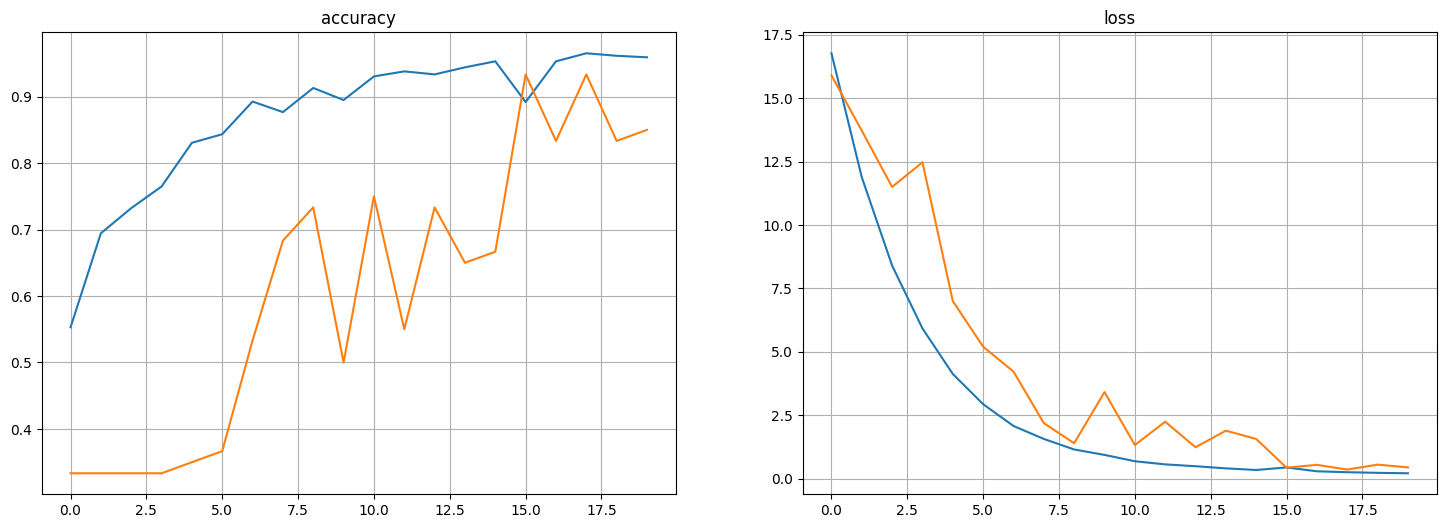

In [27]:
fig, ax = plt.subplots(1,2, figsize = (18, 6))
for x in history.history.keys() :
    if  'accuracy' in x :
        ax[0].plot(history.history[x], label = x)
    else :
        ax[1].plot(history.history[x], label = x)
ax[0].title.set_text('accuracy')
ax[1].title.set_text('loss')
ax[0].grid()
ax[1].grid()
fig.savefig(f'{file_name}_plots.png', bbox_inches='tight')

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc:.2f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7854 - loss: 0.9446
Test Accuracy: 0.81


W0000 00:00:1724812934.477453     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
